# Partial Differential Equations - Stefan problem

In this project we will consider the one dimensional Stefan problem with different types of boundary conditions.

### Constant boundary condition

In [382]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sympy import *
from scipy.optimize import curve_fit

In [2]:
def quadratic(x, a, b, c):
    return a*x*x + b*x + c

def quadratic_prim(x, h, a, b, c):
    return (quadratic(x+h, a, b, c) \
            - quadratic(x, a, b, c)) / h

def newton_rhapson2(x, h, a, b, c, epsilon):
    step = 0
    while step < 10**6:
        new_x = x - quadratic(x, a, b, c) \
        / quadratic_prim(x, h, a, b, c)
        new_x = abs(new_x)
        q = quadratic(new_x, a, b, c)
        if abs(q) < epsilon:
            return new_x
        x = new_x
        step += 1
    return x

In [213]:
def finite_difference_method2(t_max, dt, beta=1, M=10):
    N = t_max + 1
    ksi = np.linspace(0, 1, M+1)
    dx = ksi[1] - ksi[0]
    s = [0, 0]
    r = dt/(dx*dx)
    v = dt/dx
    
    x = symbols('x')
    alpha = nsolve(np.sqrt(np.pi)*beta*x*erf(x)*exp(x**2) - 1, x, 1)
    
    A = 1/(2*dx**2)*gen_matrixA(M+1)
    B = 1/(8*dx)*gen_matrixB(ksi[1:])
    I = np.identity(M)
    
    f = np.zeros(len(ksi))
    for j in range(len(ksi)):
        f[j] = 1 - (math.erf(alpha*ksi[j])/math.erf(alpha))
    
    result = np.zeros((N, M+1))
    result[0] = f
    st = np.zeros(N)
    old_f = f[1:]
    
    a = beta*ksi[M]/(2*dt)
    
    for i in range(1, N):
        s_error = 10**(-4)
        while s_error > 10**(-8):
            sn_12 = (s[1] + s[0])/2
            sp = (s[1] - s[0])/dt

            L = A - (sn_12/dt)*I + sp*B
            R = -(sn_12/dt)*I - sp*B - A
            D = np.zeros(M)
            D[0] = 1/(2*dx*dx) - sp/(8*dx)*ksi[1]

            new_f = np.linalg.inv(L) @ (R @ old_f - 2*D)

            b = -(beta*ksi[M]/dt)*s[0] + 2*beta*r/v + new_f[M-1] - old_f[M-1]
            c = beta*ksi[M]/(2*dt)*s[0]*s[0] - 2*beta*r/v*s[0] + (2*r + s[0])*new_f[M-1] + \
                (2*r - s[0])*old_f[M-1] - 2*r*(new_f[M-2] + old_f[M-2])
            s_old = s[1]
            s_new = newton_rhapson2(s[1], 10**(-6), a, b, c, 10**(-6))
            s[1] = s_new
            s_error = abs(s_new - s_old)

        s = [s_new, s_new]
        st[i] = s_new
        f[0] = 1
        f[1:] = new_f
        f[-1] = 0
        result[i] = f
        old_f = new_f
        print(i)
    return result, np.sqrt(st)

In [294]:
def ana_soli(t_max, dt, beta, M = 10):
    x = symbols('x')
    alpha = nsolve(np.sqrt(np.pi)*beta*x*erf(x)*exp(x**2) - 1, x, 1)
    ts = np.arange(0, t_max+dt, 1)*dt
    ksi = np.linspace(0, 1, M+1)
    U_ana = [0]*len(ts)
    U_ana[0] = np.zeros(M)
    s_ana = 2*alpha*np.sqrt(ts)
    for i in range(1, len(ts)):
        U = np.zeros(len(ksi))
        for j in range(len(ksi)):
            U[j] = 1 - (math.erf(alpha*ksi[j])/math.erf(alpha))
        U_ana[i] = U
    return U_ana, s_ana

In [330]:
def error_dx(dt, beta, M):
    l = []
    for i in range(len(M)):
        print(i)
        t_max = 10
        analytical = ana_soli(t_max, dt, beta, M[i])[0][-1]
        numerical = finite_difference_method2(t_max, dt, beta, M[i])[0][-1]
        res = [np.sqrt((1/M[i])*(analytical[j] - numerical[j])**2) for j in range(len(analytical))]
        nres = np.vstack(res)
        l.append(np.sum(nres))
    return l

In [342]:
M = [1000, 500, 100, 50, 10]
dt = 0.1
beta = 1

In [332]:
dx_error = error_dx(dt, beta, M)

0
1
2
3
4
5
6
7
8
9
10
1
1
2
3
4
5
6
7
8
9
10
2
1
2
3
4
5
6
7
8
9
10
3
1
2
3
4
5
6
7
8
9
10
4
1
2
3
4
5
6
7
8
9
10


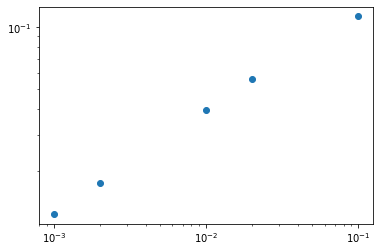

In [333]:
plt.scatter(1/np.array(M), dx_error)
plt.yscale("log")
plt.xscale("log")

In [334]:
def error_dt(dts, beta, M):
    l = []
    for i in range(len(dts)):
        print(i)
        t_max = 10
        analytical = [ana_soli(t_max, dts[i], beta, M)[0][k][int(M/2)] for k in range(t_max)]
        numerical = finite_difference_method2(t_max, dts[i], beta, M)[0][:, int(M/2)]
        res = [np.sqrt((dts[i])*(analytical[j] - numerical[j])**2) for j in range(len(analytical))]
        nres = np.vstack(res)
        l.append(np.sum(nres))
    return l

In [335]:
M = 10
dts = [10**(-i) for i in range(2, 10)]
beta = 1

In [336]:
dts

[0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07, 1e-08, 1e-09]

In [337]:
dt_error = error_dt(dts, beta, M)

0
1
2
3
4
5
6
7
8
9
10
1
1
2
3
4
5
6
7
8
9
10
2
1
2
3
4
5
6
7
8
9
10
3
1
2
3
4
5
6
7
8
9
10
4
1
2
3
4
5
6
7
8
9
10
5
1
2
3
4
5
6
7
8
9
10
6
1
2
3
4
5
6
7
8
9
10
7
1
2
3
4
5
6
7
8
9
10


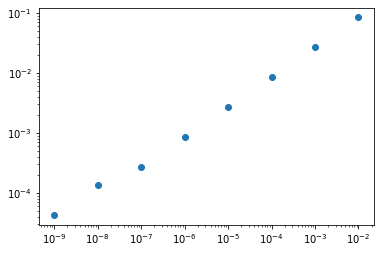

In [338]:
plt.scatter(dts, dt_error)
plt.yscale("log")
plt.xscale("log")

In [383]:
def linear(x, a):
    return a*x

In [392]:
params, pcov = curve_fit(linear, np.log(dts), np.log(dt_error), p0=[2])

In [393]:
1/params

array([2.00186482])

In [360]:
z = np.polyfit(np.log(dts), np.log(dt_error), 1)
z

array([ 0.47089596, -0.42562599])

In [386]:
p = np.log(dt_error[0]/dt_error[1])/np.log(10)
p

0.49999986635959953

In [387]:
params, pcov = curve_fit(linear, np.log(1/np.array(M)), np.log(dx_error), p0=[1])

In [390]:
1/params

array([1.47884521])

In [344]:
z = np.polyfit(np.log(1/np.array(M)), np.log(dx_error), 1)
z

array([ 0.48341714, -1.03190024])

In [389]:
p = np.log(dx_error[4]/dx_error[3])/np.log(10)
p

0.30213252132988644

In [6]:
t = 10
dt = 0.01
beta = 0.2
M1 = 10
M2 = 10

In [21]:
fdm2 = finite_difference_method2(t, dt, beta, M1)
ana2 = ana_soli(t, dt, beta, M2)

In [22]:
len(fdm2[0]), len(ana2[0])

(26, 26)

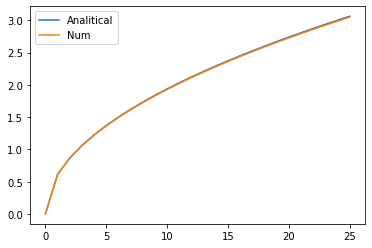

In [23]:
plt.plot(ana2[1])
plt.plot(fdm2[1])
plt.legend(["Analitical", "Num"])

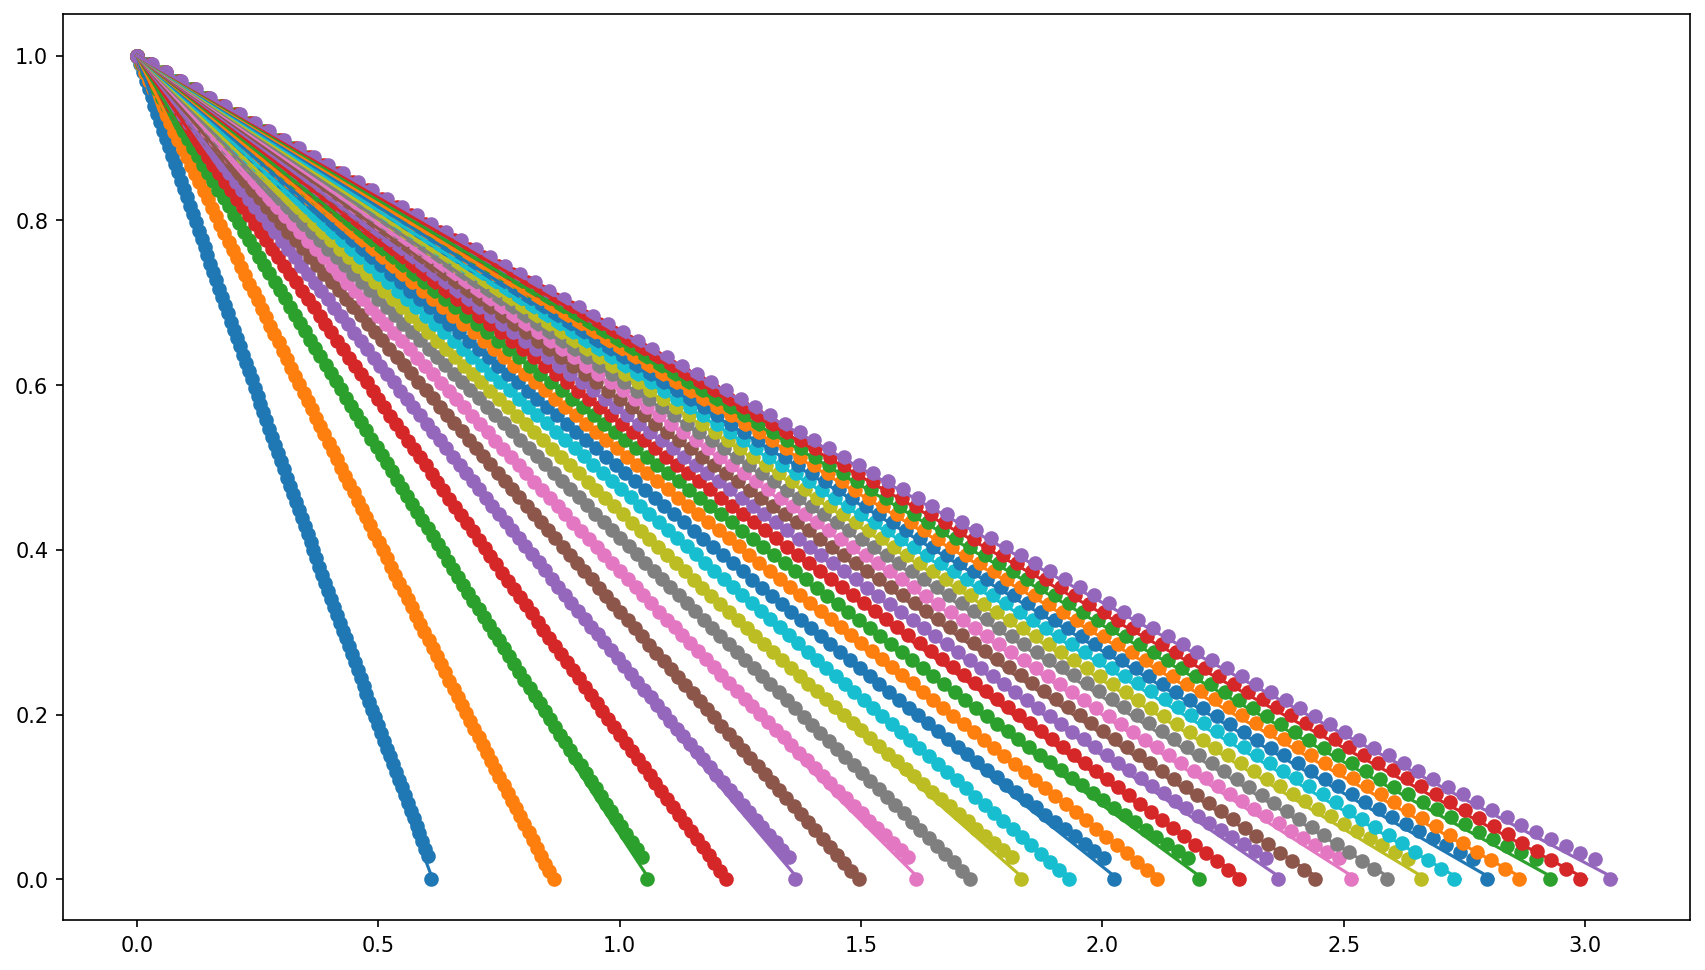

In [24]:
plt.figure(figsize = (14, 8), dpi = 150)
ksi2 = np.linspace(0, 1, M2 + 1)
ksi1 = np.linspace(0, 1, M1 + 1)
for i in range(1, len(ana2[0])):
    plt.plot(ksi2*ana2[1][i], ana2[0][i])
for i in range(1, len(fdm2[0])):
    plt.scatter(ksi1*fdm2[1][i], fdm2[0][i])

### Time dependent boundary condition

In [5]:
def gen_matrixA(M):
    A = np.zeros((M-1, M-1))
    for i in range(M-1):
        A[i][i] = -2
        if 1 <= i < M-1:
            A[i-1][i] = 1
        if 0 <= i < M-2:
            A[i+1][i] = 1
    return A

def gen_matrixB(xs):
    M = len(xs)
    B = np.zeros((M, M))
    for i in range(M):
        if 1 <= i < M:
            B[i-1][i] = xs[i-1]
        if 0 <= i < M-1:
            B[i+1][i] = -xs[i+1]
    return B

def quartic(x, t, F_new, F_old, M, beta, dt, dx, ksi, s):
    r = dt/dx**2
    v = dt/dx
    return (2*r*(t[1]+t[0])*(F_new[M-1]+F_old[M-1]))-(4*beta/v)*(r+((ksi[M]/(4*dx))*(x**2-s[0]**2)))*(x**2-s[0]**2)

def quartic_prim(x, h, t, F_new, F_old, M, beta, dt, dx, ksi, s):
    return (quartic(x+h, t, F_new, F_old, M, beta, dt, dx, ksi, s) \
            - quartic(x, t, F_new, F_old, M, beta, dt, dx, ksi, s)) / h

def newton_czy(x, h, t, F_new, F_old, M, beta, dt, dx, ksi, epsilon, s):
    step = 0
    while step < 10**6:
        new_x = x - quartic(x, t, F_new, F_old, M, beta, dt, dx, ksi, s) \
        / quartic_prim(x, h, t, F_new, F_old, M, beta, dt, dx, ksi, s)
        new_x = abs(new_x)
        #if abs(x - new_x) < epsilon:
        q = quartic(new_x, t, F_new, F_old, M, beta, dt, dx, ksi, s)
        if abs(q) < epsilon:
            return new_x
        x = new_x
        step += 1
    return x

def finite_difference_method(t_max, dt, beta=1, M=10):
    ts = np.arange(0, t_max+dt, 1)*dt
    print(ts)
    print(len(ts))
    N = len(ts)
    ksi = np.linspace(0, 1, M+1)
    dx = ksi[1] - ksi[0]
    gamma = 1/np.sqrt(beta)
    s = [0, 0]

    A = 1/(2*dx**2)*gen_matrixA(M+1)
    B = 1/(4*dx)*gen_matrixB(ksi[1:])
    I = np.identity(M)
    
    f = 1 - ksi
    
    result = np.zeros((N, M+1))
    result[0] = f
    st = np.zeros(N)
    old_f = f[1:]
    
    for i in range(1, N):
        s_error = 10**(-4)
        while s_error > 10**(-8):
            tn_12 = (ts[i]+ts[i-1])/2
            sn_12 = (s[1] + s[0])/2
            sp = (s[1] - s[0])/dt

            L = tn_12*A - sn_12**2 * (0.5 + tn_12/dt)*I + tn_12*sn_12*sp*B
            R = -tn_12*A + sn_12**2 * (0.5 - tn_12/dt)*I - tn_12*sn_12*sp*B
            D = np.zeros(M)
            if i == 1:
                D[0] = -(tn_12/(2*dx**2) + (ksi[1]*tn_12*sn_12*(s[1]-s[0])/dt)/(4*dx))*((np.exp(ts[i])-1)/ts[i] + 1)
            else:
                D[0] = -(tn_12/(2*dx**2) + (ksi[1]*tn_12*sn_12*(s[1]-s[0])/dt)/(4*dx))*((np.exp(ts[i])-1)/ts[i] \
                                                                                       + (np.exp(ts[i-1])-1)/(ts[i-1]))
            new_f = np.linalg.inv(L) @ (R @ old_f + D)
            s_old = s[1]
            s_new = newton_czy(s[1], 10**(-6), [ts[i],ts[i-1]], new_f, old_f, M, beta, dt, dx, ksi, 10**(-6), s)
            s[1] = s_new
            s_error = abs(s_new - s_old)
        if i % 1000== 0:
            print(i)
        s = [s_new, s_new]
        st[i] = s_new
        f[0] = (np.exp(ts[i])-1)/ts[i] + (np.exp(ts[i-1])-1)/(ts[i-1]) - f[0] if i > 1 else 1
        f[1:] = new_f
        f[-1] = 0
        U = f*ts[i]
        result[i] = U
        old_f = new_f
    return result, st

In [6]:
def ana_sol(t_max, dt, beta, M = 10):
    ts = np.arange(0, t_max+dt, 1)*dt
    ksi = np.linspace(0, 1, M+1)
    gamma = 1/np.sqrt(beta)
    s_ana = np.zeros(len(ts))
    U_ana = [0]*len(ts)
    for i in range(1, len(ts)):
        s_ana[i] = gamma*ts[i]
        U_ana[i] = np.exp(ts[i] - s_ana[i] * ksi) - 1
    return U_ana, s_ana

### Order of accuracy

In [7]:
def error_dt(dt, beta, M):
    l = []
    for i in range(len(dt)):
        t_max = 1/dt[i]
#         print(t_max)
#         print(dt)
        analytical = ana_sol(t_max, dt[i], beta, M)[0][-1]
        numerical = finite_difference_method(t_max, dt[i], beta, M)[0][-1]
        res = [abs(analytical[j] - numerical[j]) for j in range(len(analytical))]
        nres = np.vstack(res)
        l.append(np.sum(nres)/len(nres))
        #l.append(abs(analytical-numerical))
    return l

In [37]:
def error_dx(dt, beta, M):
    l = []
    for i in range(len(M)):
        print(i)
        t_max = 1
#         print(t_max)
#         print(dt)
        analytical = ana_sol(t_max, dt, beta, M[i])[0][-1]
        numerical = finite_difference_method(t_max, dt, beta, M[i])[0][-1]
        res = [np.sqrt((1/M)*(analytical[i] - numerical[i])**2) for i in range(len(analytical))]
        nres = np.vstack(res)
        l.append(np.sum(nres))
        #l.append(abs(analytical-numerical))
    return l

In [28]:
def error_dx(M, dt, beta):
    l = []
    t_max = 1/dt
    for i in range(len(M)):
        print(i)
        analytical = ana_sol(t_max, dt, beta, M[i])[1][:,1]
        numerical = finite_difference_method(t_max, dt, beta, M[i])[1][:,1]
        res = [abs(analytical[i] - numerical[i]) for i in range(len(analytical))]
        res = np.vstack(res)
        l.append(np.sum(res)/len(res))
    return l

In [8]:
dt = [10**-5, 10**-4, 10**-3, 10**-2]

In [9]:
dt_error = error_dt(dt, 1, 10)

[0.0000e+00 1.0000e-05 2.0000e-05 ... 9.9998e-01 9.9999e-01 1.0000e+00]
100001
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
[0.000e+00 1.000e-04 2.000e-04 ... 9.998e-01 9.999e-01 1.000e+00]
10001
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
[0.    0.001 0.002 ... 0.998 0.999 1.   ]
1001
1000
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0

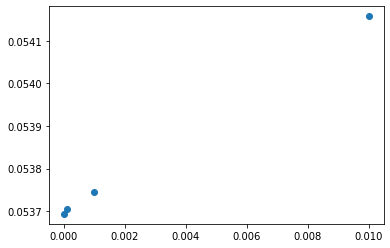

In [23]:
plt.scatter(dt, dt_error)
#plt.yscale("log")
#plt.xscale("log")

In [40]:
M = [100, 10]

In [41]:
dx_error = error_dx(10, 1, M)

0
[  0  10  20  30  40  50  60  70  80  90 100]
11


C:\Users\48791\AppData\Local\Temp/ipykernel_16548/1022636482.py:33: RuntimeWarning: divide by zero encountered in double_scalars
  new_x = x - quartic(x, t, F_new, F_old, M, beta, dt, dx, ksi, s) \
C:\Users\48791\AppData\Local\Temp/ipykernel_16548/1022636482.py:27: RuntimeWarning: invalid value encountered in double_scalars
  return (quartic(x+h, t, F_new, F_old, M, beta, dt, dx, ksi, s) \


KeyboardInterrupt: 

In [ ]:
plt.scatter(1/M, dx_error)
plt.yscale("log")
plt.xscale("log")

In [ ]:
z = np.polyfit(np.log([0.0001, 0.001, 0.01, 0.1]), np.log(dt_error), 1)

In [ ]:
dx_error = error_dx([10, 100, 1000], 1, 0.01)

In [ ]:
plt.scatter([0.0001, 0.001, 0.01, 0.1], dt_error)
plt.yscale("log")
plt.xscale("log")

In [ ]:
dt = 0.001
#dt2 = 0.1
beta = 1
M1 = 10
M2 = 10

In [8]:
ana = ana_sol(dt, beta, M2)

NameError: name 'ana_sol' is not defined

In [9]:
fdm = finite_difference_method(dt, beta, M1)

NameError: name 'finite_difference_method' is not defined

In [10]:
ana[0]

NameError: name 'ana' is not defined

In [11]:
plt.plot(ana[1])
plt.plot(fdm[1], alpha=0.5)
plt.legend(["Analitical", "Num"])

NameError: name 'ana' is not defined

In [12]:
plt.figure(figsize = (14, 8), dpi = 150)
ksi2 = np.linspace(0, 1, M2 + 1)
ksi1 = np.linspace(0, 1, M1 + 1)
for i in range(1, len(ana[0])):
    plt.plot(ksi2*ana[1][i], ana[0][i])
for i in range(1, len(fdm[0])):
    plt.scatter(ksi1*fdm[1][i], fdm[0][i])

NameError: name 'ana' is not defined

<Figure size 2100x1200 with 0 Axes>

In [13]:
def finite_difference_method3(t_max, dt, beta=1, M=10, epsilon=0.5, omega=np.pi/2):
    ts = np.arange(0, t_max+dt, 1)*dt
    N = len(ts)
    ksi = np.linspace(0, 1, M+1)
    dx = ksi[1] - ksi[0]
    s = [0, 0]
    r = dt/(dx*dx)
    v = dt/dx
    
    x = symbols('x')
    alpha = nsolve(np.sqrt(np.pi)*beta*x*erf(x)*exp(x**2) - 1, x, 1)
    
    A = 1/(2*dx**2)*gen_matrixA(M+1)
    B = 1/(4*dx)*gen_matrixB(ksi[1:])
    I = np.identity(M)
    
    f = np.zeros(len(ksi))
    for j in range(len(ksi)):
        f[j] = 1 - (math.erf(alpha*ksi[j])/math.erf(alpha))
    
    result = np.zeros((N, M+1))
    result[0] = f
    st = np.zeros(N)
    old_f = f[1:]
    
    a = beta*ksi[M]/(2*dt)
    
    for i in range(1, N):
        s_error = 10**(-4)
        while s_error > 10**(-7):
            sn_12 = (s[1] + s[0])/2
            sp = (s[1] - s[0])/dt
            tn_12 = (ts[i]+ts[i-1])/2

            L = tn_12*A - sn_12**2 * (0.5 + tn_12/dt)*I + tn_12*sn_12*sp*B
            R = -tn_12*A + sn_12**2 * (0.5 - tn_12/dt)*I - tn_12*sn_12*sp*B
            D = np.zeros(M)

            if i > 1:
                D[0] = -(tn_12/(2*dx**2) + (ksi[1]*tn_12*sn_12*(s[1]-s[0])/dt)/(4*dx))*((1 - epsilon*np.sin(omega*ts[i]))/t[i] \
                                                                                   + (1 - epsilon*np.sin(omega*ts[i-1]))/t[i - 1])
            else:
                D[0] = -(tn_12/(2*dx**2) + (ksi[1]*tn_12*sn_12*(s[1]-s[0])/dt)/(4*dx))*((1 - epsilon*np.sin(omega*ts[i]))/t[i] \
                                                                                   + 1)
            new_f = np.linalg.inv(L) @ (R @ old_f + D)

            b = -(beta*ksi[M]/dt)*s[0] + 2*beta*r/v + new_f[M-1] - old_f[M-1]
            c = beta*ksi[M]/(2*dt)*s[0]*s[0] - 2*beta*r/v*s[0] + (2*r + s[0])*new_f[M-1] + \
                (2*r - s[0])*old_f[M-1] - 2*r*(new_f[M-2] + old_f[M-2])
            s_old = s[1]
            s_new = newton_rhapson2(s[1], 10**(-6), a, b, c, 10**(-6))
            s[1] = s_new
            s_error = abs(s_new - s_old)
        
        s = [s_new, s_new]
        st[i] = s_new
        f[0] = (1 - epsilon*np.sin(omega*ts[i]))/t[i] + (1 - epsilon*np.sin(omega*ts[i-1]))/t[i - 1] - f[0] if i > 1 else 1
        f[1:] = new_f
        f[-1] = 0
        result[i] = f
        old_f = new_f
    return result, np.sqrt(st)

In [14]:
t = 25
dt = 1
beta = 5
M1 = 100
M2 = 10

In [15]:
fdm2 = finite_difference_method2(t, dt, beta, M1)

NameError: name 'gen_matrixA' is not defined

In [16]:
fdm3 = finite_difference_method3(t, dt, beta, M1)

NameError: name 'gen_matrixA' is not defined

In [17]:
plt.plot(fdm2[1])

NameError: name 'fdm2' is not defined

In [18]:
plt.figure(figsize = (14, 8), dpi = 150)
ksi3 = np.linspace(0, 1, M1 + 1)
for i in range(4, 9):
    plt.plot(ksi3, fdm3[0][i])

NameError: name 'fdm3' is not defined

<Figure size 2100x1200 with 0 Axes>

## useful

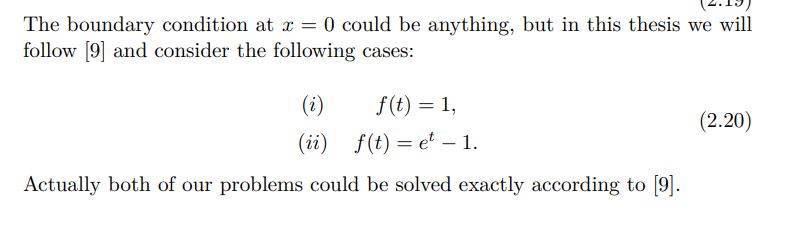

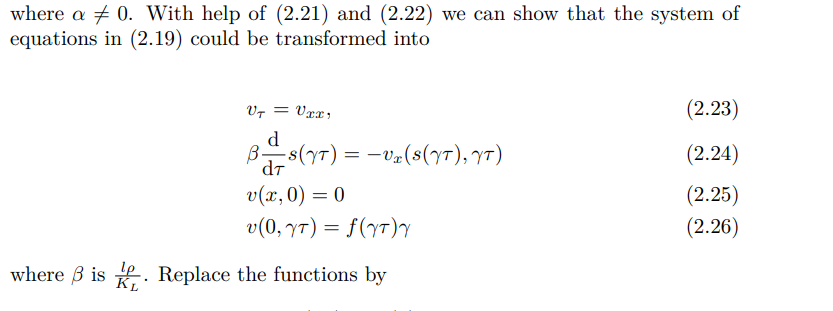

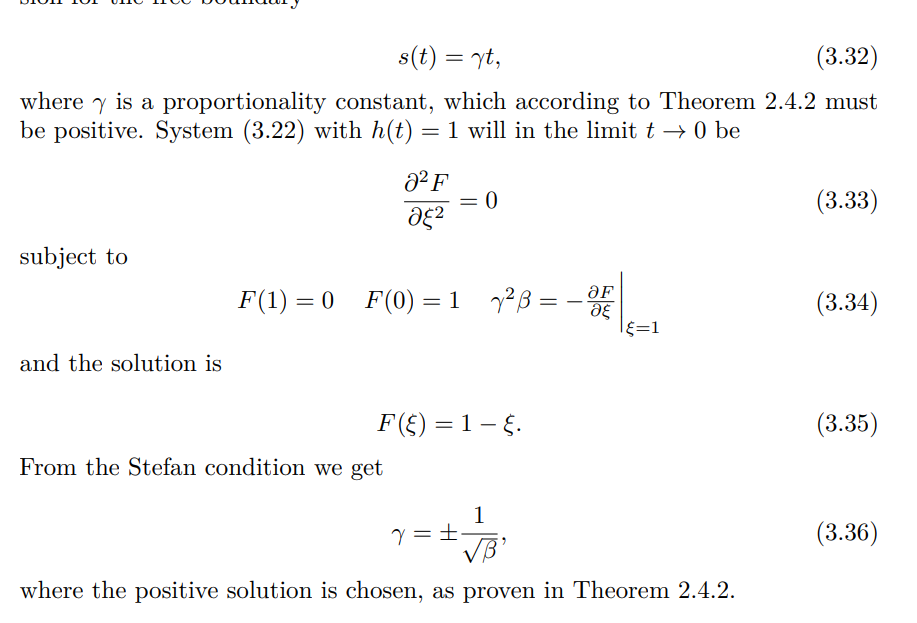

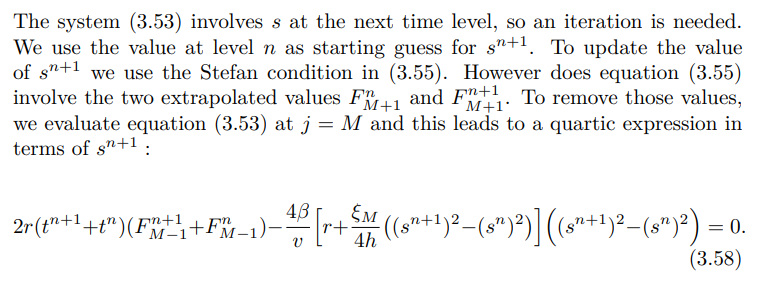

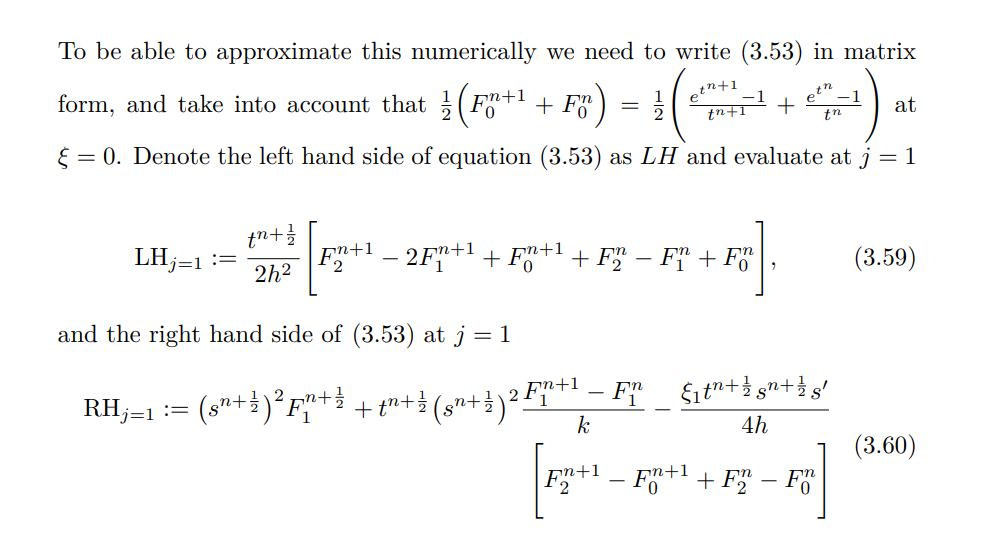

In [203]:
def ana_soliii(t_max, dt, beta, M = 10):
    gamma = 1/beta
    ts = np.arange(0, t_max+dt, 1)*dt
    ksi = np.linspace(0, 1, M+1)
    s_ana = np.zeros(len(ts))
    U_ana = [0]*len(ts)
    for i in range(1, len(ts)):
        s_ana[i] = gamma*ts[i]
        U_ana[i] = (1 - ksi)*s_ana[i]
    return U_ana, s_ana 

#### s like surface, h like height and we are flying